In [1]:
import numpy as np



import matplotlib.pylab as plt



In [2]:
from tqdm.notebook import trange


In [3]:
n = 100
p = n
d= 3

In [4]:
idx = np.round(np.linspace(0,n,num=(d+2))[1:(d+1)])

idx

X= np.zeros([n,n])
for i in range(n):
    for j in range(0,i):
        X[i,j] = np.abs(j-i)+1

X[:,0]=1

# X= np.random.normal(0,1,[n,n])


idx = np.round(np.linspace(0,n,num=(d+2))[1:(d+1)]).astype('int')

w0 = np.zeros([p])
w0[idx] = np.random.randn(d)+5
psi = X@w0


y = psi + np.random.randn(n) * 0.1


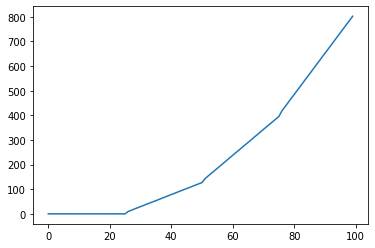

In [5]:
plt.plot(y)

In [6]:
X2 = X.T@X

In [7]:
Xy = X.T@y

In [8]:
Q,Lam,_ = np.linalg.svd(X2)

In [9]:
Lam = Lam[:(p-1)]
Q = Q[:,:(p-1)]

In [10]:
theta = np.random.uniform(0,1,p) #np.linalg.solve(X2+np.eye(p),Xy) 

sigma2 = np.sum((y-X@theta)**2)/n

mu = np.random.uniform(0,1,1)
lam = np.random.uniform(0,1,p)*10

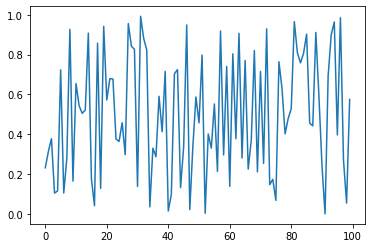

In [11]:
plt.plot(theta)

In [12]:

def Sample_a(theta,sigma2):
    #inverse gaussain

    a = np.zeros(p)
    zero_idx = np.abs(theta)==0
    non_zero_idx = np.logical_not(zero_idx)

    ig_m = lam[non_zero_idx]* np.sqrt(sigma2)/ np.abs(theta[non_zero_idx])
    a[non_zero_idx] = 1/np.random.wald(ig_m, 1,np.sum(non_zero_idx) )


    a[zero_idx] = np.random.gamma(0.5,1/0.5, np.sum(zero_idx))
    return a

In [13]:
def inverse_gaussian_density(a, theta,lam,sigma):
    return  -np.log(2*np.pi)/2 - np.log(a)/2 - a* ( np.abs(theta)/a - lam*sigma)**2/2/(lam*sigma)**2

In [14]:
def SampleSlabIndicator(mu,lam,a,theta,sigma2):

    p_slab = -mu/lam/np.sqrt(sigma2)

    p_spike = np.log(-np.expm1(p_slab)) #np.log(1- np.exp(p_slab ))

    w1 = p_spike
    w2 = p_slab + inverse_gaussian_density(a,theta,lam,np.sqrt(sigma2))

    slab_indicator = np.argmax(np.vstack([w1,w2]) + np.random.gumbel(0,1,[2,p]),0) ==1
    
    return slab_indicator

In [15]:
def SampleTheta(lam, a, sigma2, slab_indicator):

    a_star = np.zeros(p)

    a_star[slab_indicator]= a[slab_indicator]

    a_starlam = np.diag(a_star*lam**2)

    a_starlam_sub_inv = np.diag(1/ (a_star[slab_indicator]*lam[slab_indicator]**2))


    # Q_sub = Q[slab_indicator,]
    # Omega_sub = a_starlam_sub - a_starlam_sub@ Q_sub@ np.linalg.solve(1/Lam + Q_sub.T@ a_starlam_sub @Q_sub, Q_sub.T)@a_starlam_sub

    A = (X2[slab_indicator][:,slab_indicator] + a_starlam_sub_inv)

    theta0 = np.random.randn(slab_indicator.sum())

    A_inv = np.linalg.inv(A)

    theta = np.zeros(p)

    theta[slab_indicator] = np.linalg.cholesky(A_inv) @theta0 * np.sqrt(sigma2) + A_inv@Xy[slab_indicator]
    
    return theta

In [16]:
def ExpCDF(x,lam):
    return 1- np.exp(-x/lam)

def ExpInvCDF(y,lam):
    return  -np.log1p(-y)*lam

In [17]:
def SampleT(mu, lam, slab_indicator, theta):
    t = ExpInvCDF(ExpCDF(mu, lam) * np.random.uniform(0,1,p), lam) - mu
    t[slab_indicator] = np.abs(theta)[slab_indicator]
    return t

In [18]:
def SampleLam(t,mu,sigma2):
    # lam prior: a,b
    a = 1
    b = 1
    
    beta = (t+mu)
    lam = 1/ np.random.gamma(a+1, 1/(beta/np.sqrt(sigma2)+ b ),p)
    return lam

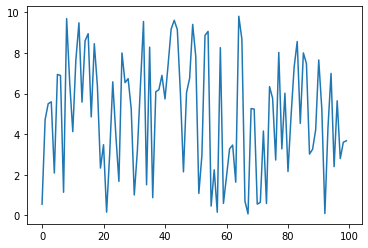

In [19]:
plt.plot(lam)

In [20]:
def SampleMu(t, lam):
    m = 1/np.sum(1/lam)
    
    if(np.min(t)<0):
        lb = ExpCDF(-np.min(t),m)
    else:
        lb = 0
    
    if lb< (1- 1E-2):
        mu = ExpInvCDF ( (1- lb)* np.random.uniform(0,1,1)+lb, m )
    else:
        mu = -np.min(t)
    
    
    return mu

In [21]:
def SampleSigma2(theta, t,mu,lam):

    b1 = np.sum((y-X@theta)**2)/2 +  np.sum((t+mu)/lam)
    a1 = n/2+p/2

    return 1/np.random.gamma(a1, 1/b1,1)

In [22]:
trace_theta=[]

In [23]:
# mu= 0.001

In [40]:
for k in range(10000):
    a = Sample_a(theta,sigma2)
    slab_indicator = SampleSlabIndicator(mu,lam,a,theta,sigma2)
    theta = SampleTheta(lam, a, sigma2, slab_indicator)
    t = SampleT(mu, lam, slab_indicator, theta)
    mu = SampleMu(t,lam)
    lam = SampleLam(t,mu,sigma2)
    sigma2 = SampleSigma2(theta,t,mu,lam)
    
    if k>1000:
        trace_theta.append(theta)


In [41]:
slab_indicator.sum()

70

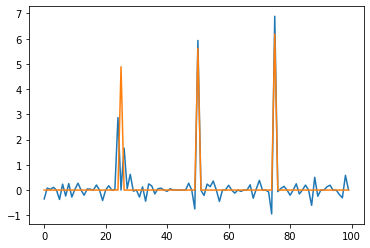

In [42]:
plt.plot(theta)
plt.plot(w0)

In [43]:
theta_mat = np.vstack(trace_theta)

In [44]:
from statsmodels.tsa.stattools import acf

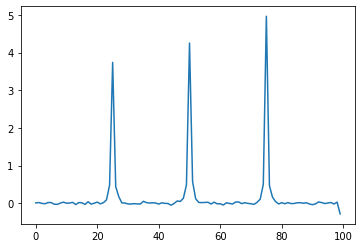

In [45]:
plt.plot(theta_mat.mean(0))

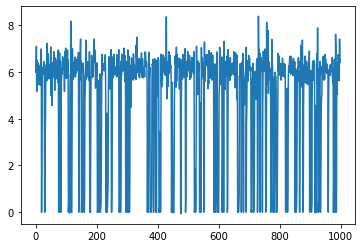

In [30]:
plt.plot(theta_mat[:,idx[2]])

/home/shared/anaconda3/envs/leo/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


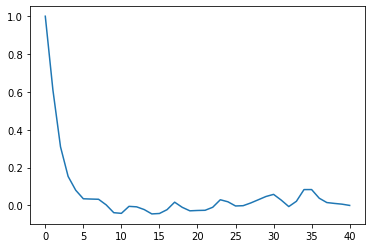

In [31]:
plt.plot(acf(theta_mat[:,idx[0]]))

In [32]:
sigma2

array([0.54250148])

In [33]:
mu

array([0.02790641])

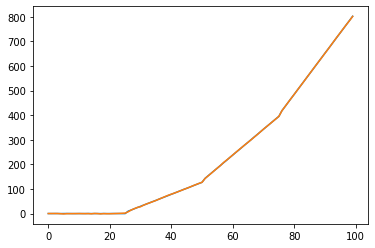

In [34]:
plt.plot(y)
plt.plot(X@theta)

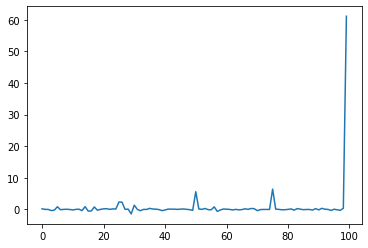

In [35]:
plt.plot(theta)

In [36]:
SampleSlabIndicator(mu,lam,a,theta,sigma2).sum()

86